In [16]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import math
import pandas as pd
import numpy as np
import random
from deap import creator, base, tools, algorithms
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold


def avg(l):
    """
    Returns the average between list elements
    """
    return (sum(l)/float(len(l)))


def calculate_equivalence_classes(data, condition_attrs):
    # 取出条件属性的列索引
    # 设置条件属性为索引
    # print(condition_attrs)
    data_indexed = data.set_index(condition_attrs)
    # 按照索引分组并将分组内结果合并为列表
    equivalence_classes = data_indexed.groupby(level=condition_attrs)[data.columns[0]].apply(list).to_dict()
    return equivalence_classes

def getFitness(data,decision_attr,individual):
    # 计算D的信息熵
    total_records = len(data)
    decision_counts = data[decision_attr].value_counts()
    decision_prob = decision_counts / total_records
    entropy_D = -(decision_prob * np.log2(decision_prob)).sum()

    feature_columns = [col for col in data.columns if col not in ['id','target']]
    selected_features = [feature_columns[i] for i in range(len(feature_columns)) if individual[i] == 1]

    equivalence_classes = calculate_equivalence_classes(data,selected_features)
    equivalence_classes_dec = calculate_equivalence_classes(data, decision_attr)

    rule_confidences = []
    entropy_DB = 0
    total_rule=0

    for equivalence_class in equivalence_classes.values():
        class_size = len(equivalence_class)
        class_prob = class_size / total_records
        for key_decision in equivalence_classes_dec.keys():
            x=set(equivalence_class).intersection(equivalence_classes_dec.get(key_decision))
            if len(x)>total_records*0.0:
                y = 1-len(x) / class_size
                total_rule+=len(x)
                rule_confidences.append(y)
            if len(x)>0:
                decision_prob = len(x) / class_size
                entropy_DB -= class_prob * decision_prob * math.log(decision_prob, 2)
    rule_confidences = np.array(rule_confidences)
    # rule_confidences = [x for x in rule_confidences if x <= 0.6]
    count = len(rule_confidences)
    if count == 0:
        return(1,);
    # if total_rule/total_records<0.1:
    #     return (1,);

    avg_confidence = np.sum(rule_confidences) / count +0.1*(entropy_D-entropy_DB)
    return(avg_confidence,)

def geneticAlgorithm(df,y,n_population, n_generation):
    """
    Deap global variables
    Initialize variables to use eaSimple
    """
    random.seed(1)
    # create individual
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # create toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat,
                     creator.Individual, toolbox.attr_bool, len(X.columns))
    toolbox.register("population", tools.initRepeat, list,
                     toolbox.individual)
    toolbox.register("evaluate", getFitness,df,y)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # initialize parameters
    pop = toolbox.population(n=n_population)
    hof = tools.HallOfFame(n_population * n_generation)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    # stats.register("max", np.max)

    # genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                   ngen=n_generation, stats=stats, halloffame=hof,
                                   verbose=True)

    # return hall of fame
    top_5_hof = sorted(hof.items, key=lambda x: x.fitness.values[0])[:1]
    for i, ind in enumerate(top_5_hof):
        print(f"Top {i+1} solution: {ind}\nFitness: {ind.fitness.values[0]}\n")
    return top_5_hof
    # return hof



In [17]:
def bestIndividual_KNN(hof):
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k)
    for ind in hof:
        df = pd.read_csv('../data/German2.csv')
        feature_columns = [col for col in df.columns if col not in ['id','target']]
        selected_features = [feature_columns[i] for i in range(len(feature_columns)) if ind[i] == 1]
        Y=df["target"]
        X=df[selected_features]
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        accuracy_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
        mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
        return mean_accuracy,selected_features

In [18]:
from sklearn.model_selection import StratifiedKFold

def bestIndividual_SVM(hof):
    def SVM(trainX, trainY, testX, testY):
        scaler = StandardScaler()
        scaler.fit(trainX)
        trainX3 = scaler.transform(trainX)
        testX3 = scaler.transform(testX)
        clf = svm.SVC(C=10, gamma=0.8, max_iter=1000)
        clf.fit(trainX3, trainY)
        test_result = clf.predict(testX3)
        precision = np.sum(test_result == testY) / testY.shape[0]
        return precision

    maxaccuracy = 0.0
    for ind in hof:
        df =pd.read_csv('../data/German.csv')
        feature_columns = ['status_account', 'duration', 'credit_history', 'purpose', 'amount', 'svaing_account',
           'present_emp', 'income_rate', 'personal_status','other_debtors',
            'residence_info', 'property', 'age', 'inst_plans','housing', 'num_credits',
            'job', 'dependents', 'telephone', 'foreign_worker']
        from sklearn.preprocessing import LabelEncoder

        labelencoder=LabelEncoder()
        for col in feature_columns:
            df[col] = labelencoder.fit_transform(df[col])
        df['target'] = df['target'].map({2 : 0, 1: 1})
        selected_features = [feature_columns[i] for i in range(len(feature_columns)) if ind[i] == 1]
        # selected_features=['status_account', 'duration', 'other_debtors', 'inst_plans', 'foreign_worker']
        Y = df["target"]
        X = df[selected_features]

        # Use stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        scores = []
        for train_index, test_index in skf.split(X, Y):
            trainX, testX = X.iloc[train_index], X.iloc[test_index]
            trainY, testY = Y.iloc[train_index], Y.iloc[test_index]
            score = SVM(trainX, trainY, testX, testY)
            scores.append(score)
        avg_score = np.mean(scores)

        if avg_score > maxaccuracy:
            maxaccuracy = avg_score
            best_feature = selected_features

    return maxaccuracy, best_feature

In [19]:
from sklearn.tree import DecisionTreeClassifier

def bestIndividual_DT(hof, df):
    for ind in hof:
        df = pd.read_csv('../data/German2.csv')
        feature_columns = [col for col in df.columns if col not in ['id','target']]
        selected_features = [feature_columns[i] for i in range(len(feature_columns)) if ind[i] == 1]
        X = df[selected_features]
        Y = df['target']
        dt = DecisionTreeClassifier(max_depth=5)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        accuracy_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

            dt.fit(X_train, y_train)

            y_pred = dt.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)

        mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    return mean_accuracy


if __name__ == '__main__':
    # get dataframe path, population number and generation number from command-line argument
    # dataframePath, n_pop, n_gen = getArguments()
    n_pop=50
    n_gen=25
    # read dataframe from csv
    df = pd.read_csv('../data/German2.csv')
    # encode labels column to numbers
    y = df['target']
    feature_columns = [ col for col in df.columns if col not in ['id','target']]
    X = df[feature_columns]
    individual = [1 for i in range(len(X.columns))]
    getFitness(df,'target',individual)
    print("Accuracy with all features: \t" +
          str(getFitness(df,'target',individual)) + "\n")

    # apply genetic algorithm
    hof = geneticAlgorithm(df,'target',n_pop, n_gen)

Accuracy with all features: 	(0.08816576743327645,)



C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min      
0  	50    	0.122763	0.0889676
1  	27    	0.101886	0.0889676
2  	31    	0.0929683	0.0881658
3  	25    	0.0896715	0.0881658
4  	34    	0.0889193	0.0881658
5  	30    	0.0885046	0.0881658
6  	28    	0.0884895	0.0881658
7  	40    	0.0885493	0.0881658
8  	32    	0.0882947	0.0881658
9  	34    	0.0882468	0.0881658
10 	29    	0.0882933	0.0881658
11 	28    	0.0882464	0.0881658
12 	30    	0.0883791	0.0881658
13 	25    	0.0882626	0.0881658
14 	36    	0.0882609	0.0881658
15 	32    	0.0883109	0.0881658
16 	35    	0.0882789	0.0881658
17 	37    	0.0882464	0.0881658
18 	31    	0.0882465	0.0881658
19 	33    	0.0883119	0.0881658
20 	32    	0.0883607	0.0881658
21 	31    	0.0882143	0.0881658
22 	35    	0.0883109	0.0881658
23 	36    	0.0882786	0.0881658
24 	36    	0.088198 	0.0881658
25 	27    	0.0882788	0.0881658
Top 1 solution: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Fitness: 0.08816576743327645



In [20]:
accuracy_KNN,individual = bestIndividual_KNN(hof)
print("-----------KNN---------------")
print(accuracy_KNN)

-----------KNN---------------
0.7406969696969699


In [21]:
print('------------特征-----------------')
print(individual)

------------特征-----------------
['status_account', 'duration', 'credit_history', 'purpose', 'amount', 'svaing_account', 'present_emp', 'income_rate', 'personal_status', 'other_debtors', 'property', 'age', 'inst_plans', 'housing', 'num_credits', 'job', 'dependents', 'foreign_worker']


In [22]:
accuracy_SVM,individual = bestIndividual_SVM(hof)
print("-----------SVM---------------")
print(accuracy_SVM)

C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklear

-----------SVM---------------
0.6966767676767677


C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\envs\py3.7\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [23]:
print("-----------DT---------------")
accuracy_DT = bestIndividual_DT(hof,df)
print(accuracy_DT)

-----------DT---------------
0.7357070707070706


In [24]:
#seed 1 n_pop=50 n_gen=25 lamda=0
#['status_account', 'duration', 'credit_history', 'other_debtors', 'inst_plans', 'dependents'] KNN=0.7238 SVM=0.7388 DT=0.7257
#seed 1 n_pop=50 n_gen=25 lamda=0.1
#['status_account', 'duration', 'credit_history', 'other_debtors', 'inst_plans', 'dependents'] KNN=0.7238 SVM=0.7388 DT=0.7257
#seed 1 n_pop=50 n_gen=25 lamda=0.2
#['status_account', 'duration', 'other_debtors', 'property', 'dependents'] KNN=0.7047 SVM=0.6996 DT=0.7037
#seed 1 n_pop=50 n_gen=25 lamda=0.3
#['status_account', 'duration', 'other_debtors', 'property', 'dependents'] KNN=0.7047 SVM=0.6996 DT=0.7037

#seed 1 n_pop=50 n_gen=25 lamda=0.4
#['status_account', 'credit_history', 'other_debtors', 'property', 'telephone'] KNN=0.7197 SVM=0.7227 DT=0.7117

#seed 1 n_pop=50 n_gen=25 lamda=0.5
#['credit_history', 'property', 'age', 'dependents'] KNN=0.6747 SVM=0.6887 DT=0.6997

#seed 1 n_pop=50 n_gen=25 lamda=0.6
#['property', 'age', 'inst_plans', 'telephone'] KNN=0.6407 SVM=0.6677 DT=0.6577

#seed 1 n_pop=50 n_gen=25 lamda=0.7
#['property', 'age', 'inst_plans', 'telephone'] KNN=0.6407 SVM=0.6677 DT=0.6577

#seed 1 n_pop=50 n_gen=25 lamda=0.8
#['property', 'age', 'inst_plans', 'telephone'] KNN=0.6407 SVM=0.6677 DT=0.6577

#seed 1 n_pop=50 n_gen=25 lamda=0.9
#['property', 'age', 'inst_plans', 'telephone'] KNN=0.6407 SVM=0.6677 DT=0.6577

#seed 1 n_pop=50 n_gen=25 lamda=1
#['property', 'inst_plans', 'dependents', 'foreign_worker'] KNN=0.6627 SVM=0.6877 DT=0.6917

In [25]:
def FN(condition_attrs, data, decision_attr):
    # 计算D的信息熵
    total_records = len(data)
    decision_counts = data[decision_attr].value_counts()
    decision_prob = decision_counts / total_records
    entropy_D = -(decision_prob * np.log2(decision_prob)).sum()

    equivalence_classes = calculate_equivalence_classes(data, condition_attrs)

    equivalence_classes_dec = calculate_equivalence_classes(data, decision_attr)

    rule_confidences = []
    entropy_DB = 0
    total_rule=0

    for equivalence_class in equivalence_classes.values():
        class_size = len(equivalence_class)
        class_prob = class_size / total_records
        for key_decision in equivalence_classes_dec.keys():
            x=set(equivalence_class).intersection(equivalence_classes_dec.get(key_decision))
            # print(len(x))
            if(len(x)>total_records*0.01):
                total_rule+=len(x)
                y = 1-len(x) / class_size
                rule_confidences.append(y)
            if (len(x)>0):
                decision_prob = len(x) / class_size
                entropy_DB -=class_prob * decision_prob * math.log(decision_prob, 2)
    rule_confidences = np.array(rule_confidences)
    count = len(rule_confidences)
    print(rule_confidences)

    print(entropy_D)
    print(entropy_DB)
    print(count)

    avg_confidence = np.sum(rule_confidences) / count +0.6*(entropy_D-entropy_DB)

    return avg_confidence

In [26]:
df = pd.read_csv('../data/German2.csv')

In [27]:
feature_columns_0=['status_account', 'duration', 'credit_history', 'other_debtors', 'inst_plans', 'dependents']
#误差0.2391 熵0.3915 FN0.2391 6
feature_columns_01=['status_account', 'duration', 'credit_history', 'other_debtors', 'inst_plans', 'dependents']
#误差0.2391 熵0.3915 FN0.2782 6
feature_columns_02=['status_account', 'duration', 'other_debtors', 'property', 'dependents']
#误差0.2069 熵0.2917 FN0.2653 5
feature_columns_03=['status_account', 'duration', 'other_debtors', 'property', 'dependents']
#误差0.2069 熵0.2917 FN0.2944 5
feature_columns_04=['status_account', 'credit_history', 'other_debtors', 'property', 'telephone']
#误差0.2162 熵0.292 FN0.3329 5
feature_columns_05=['credit_history', 'property', 'age', 'dependents']
#误差0.2437 熵0.1864 FN0.3368 4
feature_columns_06=['property', 'age', 'inst_plans', 'telephone']
#误差0.2662 熵0.1286 FN0.3434 4
feature_columns_07=['property', 'age', 'inst_plans', 'telephone']
#误差0.2662 熵0.1286 FN0.3562 4
feature_columns_08=['property', 'age', 'inst_plans', 'telephone']
#误差0.2662 熵0.1286 FN0.3691 4
feature_columns_09=['property', 'age', 'inst_plans', 'telephone']
#误差0.2662 熵0.1286 FN0.382 4
feature_columns_1=['property', 'inst_plans', 'dependents', 'foreign_worker']
#误差0.3689 熵0.049 FN0.4179 4
print(FN(feature_columns_0,df,'target'))

[0.5        0.5        0.1875     0.37837838 0.62162162 0.16666667
 0.2        0.69047619 0.30952381 0.08333333 0.62068966 0.37931034
 0.23076923 0.27777778 0.07692308 0.07692308 0.         0.
 0.07692308 0.         0.10416667 0.04878049 0.125      0.08333333]
0.8816576743327644
0.49019891602430643
24
0.47396261861512134


In [28]:
emp=[0.2391,0.2391,0.2069,0.2069,0.2162,0.2437,0.2662,0.2662,0.2662,0.2662,0.3689]
en=[0.3915,0.3915,0.2917,0.2917,0.292,0.1864,0.1286,0.1286,0.1286,0.1286,0.049]
SRM=[0.2391,0.2782,0.2653,0.2944,0.3329,0.3368,0.3434,0.3562,0.3691,0.382,0.4179]

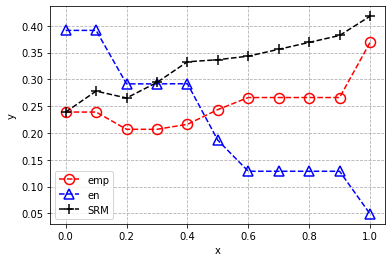

In [29]:
import matplotlib.pyplot as plt

emp = [0.2391, 0.2391, 0.2069, 0.2069, 0.2162, 0.2437, 0.2662, 0.2662, 0.2662, 0.2662, 0.3689]
en = [0.3915, 0.3915, 0.2917, 0.2917, 0.292, 0.1864, 0.1286, 0.1286, 0.1286, 0.1286, 0.049]
SRM = [0.2391, 0.2782, 0.2653, 0.2944, 0.3329, 0.3368, 0.3434, 0.3562, 0.3691, 0.382, 0.4179]

x = [i / 10 for i in range(11)]

plt.plot(x, emp,color='r',linestyle='--', marker='o', markersize=10, markerfacecolor='none', markeredgecolor='r',markeredgewidth=1.5, label='emp')
plt.plot(x, en, color='b',linestyle='--',marker='^',markersize=10, markerfacecolor='none', markeredgecolor='b',markeredgewidth=1.5, label='en')
plt.plot(x, SRM, color='k',linestyle='--',marker='+',markersize=10, markerfacecolor='none', markeredgecolor='k',markeredgewidth=1.5, label='SRM')

plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.grid(linestyle='--')

plt.xticks([i / 10 for i in range(11)][::2])
plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
def FN(condition_attrs, data, decision_attr):
    # 计算D的信息熵
    total_records = len(data)
    decision_counts = data[decision_attr].value_counts()
    decision_prob = decision_counts / total_records
    entropy_D = -(decision_prob * np.log2(decision_prob)).sum()

    equivalence_classes = calculate_equivalence_classes(data, condition_attrs)

    equivalence_classes_dec = calculate_equivalence_classes(data, decision_attr)

    rule_confidences = []
    entropy_DB = 0
    total_rule=0

    for equivalence_class in equivalence_classes.values():
        class_size = len(equivalence_class)
        class_prob = class_size / total_records
        for key_decision in equivalence_classes_dec.keys():
            x=set(equivalence_class).intersection(equivalence_classes_dec.get(key_decision))
            # print(len(x))
            if(len(x)>total_records*0.01):
                total_rule+=len(x)
                y = 1-len(x) / class_size
                rule_confidences.append(y)
            if (len(x)>0):
                decision_prob = len(x) / class_size
                entropy_DB -=class_prob * decision_prob * math.log(decision_prob, 2)

    rule_confidences = np.array(rule_confidences)
    count = len(rule_confidences)

    print(entropy_D)
    print(entropy_DB)

    avg_confidence = np.sum(rule_confidences) / count +0.1*(entropy_D-entropy_DB)

    return avg_confidence